# Fine-tuning a Semantic Segmentation Model on a Custom Dataset and Usage via the Inference API

In this example, we will finetune a semantic segmentation model on a custom dataset. We will finetune a pretrained [Segformer](https://huggingface.co/docs/transformers/model_doc/segformer) on the [`segments/sidewalk-semantic`](https://huggingface.co/datasets/segments/sidewalk-semantic) dataset, which contains labeled images of sidewalks.

Once we have finetuned the model, we will demonstrate how to deploy it using the HuggingFace Serverless Inference API.

## Setups

In [1]:
!pip install -qU datasets transformers evaluate wandb
# Tested with datasets==3.0.0, transformers==4.44.2, evaluate==0.4.3, wandb==0.18.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82

## Load the dataset

The [`sidewalk-semantic`](https://huggingface.co/datasets/segments/sidewalk-semantic) dataset consists of images of sidewalks collected in Belgium during the summer of 2021. The dataset includes
- images along with their corresponding semantic segmentation masks
- 34 distinct categories

In [ ]:
from datasets import load_dataset

dataset = load_dataset("segments/sidewalk-semantic")

dataset_infos.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/324M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 1000
    })
})

In [ ]:
dataset = dataset.shuffle(seed=111)
dataset = dataset['train'].train_test_split(test_size=0.2)
train_ds = dataset['train']
test_ds = dataset['test']

In [ ]:
train_ds[0]

{'pixel_values': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=1920x1080>}

The `pixel_values` holds the RGB image, while `label` contains the ground truth mask. The mask is a single-channel image where each pixel represents the category of the corresponding pixel in the RGB image.

## Visualize examples

The dataset includes a JSON file containing the `id2label` mapping. We need to open this file to read the category labels associated with each ID.

In [ ]:
import json
from huggingface_hub import hf_hub_download

filename = 'id2label.json'
id2label = json.load(
    open(
        hf_hub_download(
            repo_id='segments/sidewalk-semantic',
            filename=filename,
            repo_type='dataset'
        ),
        'r'
    )
)
id2label = {int(k): v for k,v in id2label.items()}
label2id = {v: k for k,v in id2label.items()}

num_labels = len(id2label)
print('id2label:', id2label)

id2label.json:   0%|          | 0.00/852 [00:00<?, ?B/s]

id2label: {0: 'unlabeled', 1: 'flat-road', 2: 'flat-sidewalk', 3: 'flat-crosswalk', 4: 'flat-cyclinglane', 5: 'flat-parkingdriveway', 6: 'flat-railtrack', 7: 'flat-curb', 8: 'human-person', 9: 'human-rider', 10: 'vehicle-car', 11: 'vehicle-truck', 12: 'vehicle-bus', 13: 'vehicle-tramtrain', 14: 'vehicle-motorcycle', 15: 'vehicle-bicycle', 16: 'vehicle-caravan', 17: 'vehicle-cartrailer', 18: 'construction-building', 19: 'construction-door', 20: 'construction-wall', 21: 'construction-fenceguardrail', 22: 'construction-bridge', 23: 'construction-tunnel', 24: 'construction-stairs', 25: 'object-pole', 26: 'object-trafficsign', 27: 'object-trafficlight', 28: 'nature-vegetation', 29: 'nature-terrain', 30: 'sky', 31: 'void-ground', 32: 'void-dynamic', 33: 'void-static', 34: 'void-unclear'}


In [ ]:
# colors for masks
sidewalk_palette = [
    [0, 0, 0],  # unlabeled
    [216, 82, 24],  # flat-road
    [255, 255, 0],  # flat-sidewalk
    [125, 46, 141],  # flat-crosswalk
    [118, 171, 47],  # flat-cyclinglane
    [161, 19, 46],  # flat-parkingdriveway
    [255, 0, 0],  # flat-railtrack
    [0, 128, 128],  # flat-curb
    [190, 190, 0],  # human-person
    [0, 255, 0],  # human-rider
    [0, 0, 255],  # vehicle-car
    [170, 0, 255],  # vehicle-truck
    [84, 84, 0],  # vehicle-bus
    [84, 170, 0],  # vehicle-tramtrain
    [84, 255, 0],  # vehicle-motorcycle
    [170, 84, 0],  # vehicle-bicycle
    [170, 170, 0],  # vehicle-caravan
    [170, 255, 0],  # vehicle-cartrailer
    [255, 84, 0],  # construction-building
    [255, 170, 0],  # construction-door
    [255, 255, 0],  # construction-wall
    [33, 138, 200],  # construction-fenceguardrail
    [0, 170, 127],  # construction-bridge
    [0, 255, 127],  # construction-tunnel
    [84, 0, 127],  # construction-stairs
    [84, 84, 127],  # object-pole
    [84, 170, 127],  # object-trafficsign
    [84, 255, 127],  # object-trafficlight
    [170, 0, 127],  # nature-vegetation
    [170, 84, 127],  # nature-terrain
    [170, 170, 127],  # sky
    [170, 255, 127],  # void-ground
    [255, 0, 127],  # void-dynamic
    [255, 84, 127],  # void-static
    [255, 170, 127],  # void-unclear
]

We can now visualize some examples from the dataset, including the RGB images, the corresponding mask, and an overlay of the mask on the image.

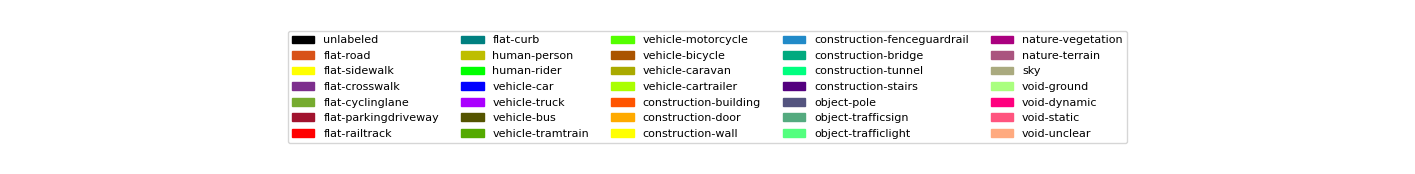

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.patches as patches

# Create and show the legend separately
fig, ax = plt.subplots(figsize=(18, 2))

legend_patches = [
    patches.Patch(color=np.array(color) / 255, label=label)
    for label, color in zip(id2label.values(), sidewalk_palette)
]

ax.legend(
    handles=legend_patches,
    loc='center',
    bbox_to_anchor=(0.5, 0.5),
    ncol=5,
    fontsize=8
)
ax.axis('off')
plt.show()

In [ ]:
for i in range(5):
    image = train_ds[i]

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    # Show the original image
    ax[0].imshow(image['pixel_values'])
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    mask_np = np.array(image['label'])

    # Create a new empty RGB image
    colored_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)

    # Assign colors to each value in the mask
    for label_id, color in enumerate(sidewalk_palette):
        colored_mask[mask_np == label_id] = color

    colored_mask_img = Image.fromarray(colored_mask, 'RGB')

    # Show the semgentation mask
    ax[1].imshow(colored_mask_img)
    ax[1].set_title('Segmentation Mask')
    ax[1].axis('off')

    # Convert the original image to RGBA to support transparency
    image_rgba = image['pixel_values'].convert('RGBA')
    colored_mask_rgba = colored_mask_img.convert('RGBA')

    # Adjust transparency of the mask
    alpha = 128 # Transparency level (0 fully transparent, 255 fully opaque)
    image_2_with_alpha = Image.new('RGBA', colored_mask_rgba.size)
    for x in range(colored_mask_rgba.width):
        for y in range(colored_mask_rgba.height):
            r, g, b, a = colored_mask_rgba.getpixel((x, y))
            image_2_with_alpha.putpixel((x, y), (r, g, b, alpha))

    superposed = Image.alpha_composite(image_rgba, image_2_with_alpha)

    # Show the mask overlay
    ax[2].imshow(superposed)
    ax[2].set_title('Mask Overlay')
    ax[2].axis('off')

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Visualize class occurrences

To gain deeper insights into the dataset, we need to plot the occurrences of each class. This will allow us to understand the distribution of classes and identify any potential biases or imbalances in the dataset.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class_counts = np.zeros(len(id2label))

for example in train_ds:
    mask_np = np.array(example['label'])
    unique, counts = np.unique(mask_np, return_counts=True)
    for u, c in zip(unique, counts):
        class_counts[u] += c

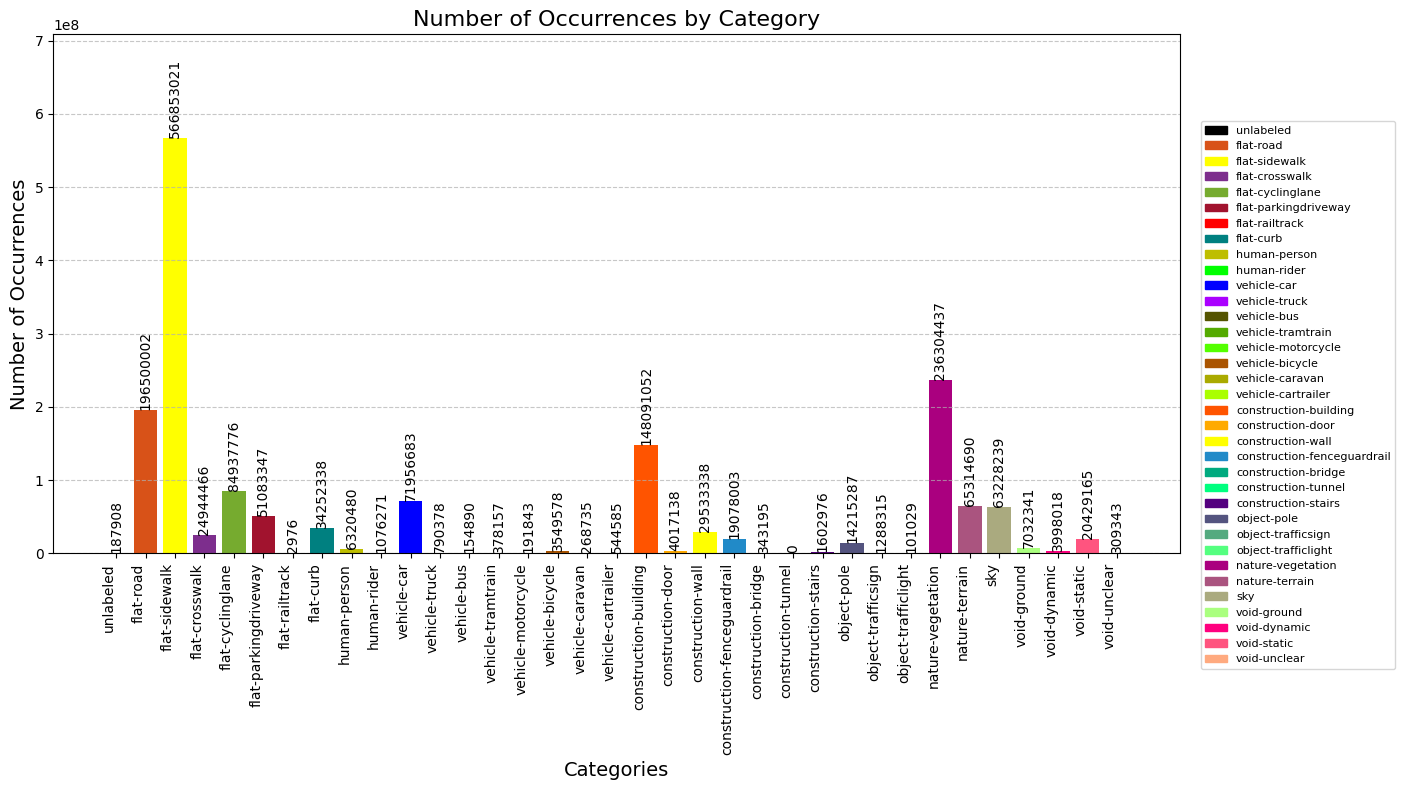

In [ ]:
labels = list(id2label.values())

# Normalize colors to be in the range [0, 1]
normalized_palette = [tuple(c / 255 for c in color) for color in sidewalk_palette]

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.bar(
    range(len(labels)),
    class_counts,
    color=[normalized_palette[i] for i in range(len(labels))]
)

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, ha='right')

ax.set_xlabel('Categories', fontsize=14)
ax.set_ylabel('Number of Occurrences', fontsize=14)
ax.set_title('Number of Occurrences by Category', fontsize=16)

ax.grid(axis='y', linestyle='--', alpha=0.7)

y_max = max(class_counts)
ax.set_ylim(0, y_max * 1.25)

for bar in bars:
    height = int(bar.get_height())
    offset = 10
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + offset,
        f'{height}',
        ha='center',
        va='bottom',
        rotation=90,
        fontsize=10,
        color='black'
    )

fig.legend(
    handles=legend_patches,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1,
    fontsize=8
)
plt.tight_layout()
plt.show()

## Initialize image processor and add data augmentation with Albumentations

In [ ]:
import albumentations as A
from transformers import SegformerImageProcessor

image_processor = SegformerImageProcessor()

In [ ]:
albumentations_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.7),
    A.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=25, val_shift_limit=20, p=0.5),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.GaussNoise(std_range=(0.1, 0.2), p=0.4)
])


def train_transforms(example_batch):
    augmented = [
        albumentations_transform(image=np.array(image), mask=np.array(label))
        for image, label in zip(example_batch['pixel_values'], example_batch['label'])
    ]

    augmented_images = [item['image'] for item in augmented]
    augmented_labels = [item['mask'] for item in augmented]

    inputs = image_processor(augmented_images, augmented_labels)
    return inputs

def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]

    inputs = image_processor(images, labels)
    return inputs

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

## Initialize model from checkpoint

We will use a pretrained Segformer model from [`nvidia/mit-b0`](https://huggingface.co/nvidia/mit-b0), which is detailed in the paper [*SegFormer: Simple an Efficient Design for Semantic Segmentation with Transformers*](https://arxiv.org/abs/2105.15203) and has been trained on ImageNet-1k.

In [ ]:
from transformers import SegformerForSemanticSegmentation

pretrained_model_name = 'nvidia/mit-b0'
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Set training arguments and connect to Weights & Biases

In [ ]:
from transformers import TrainingArguments

output_dir = 'test-segformer-b0-segments-sidewalk-finetuned'

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    learning_rate=1e-4,
    save_total_limit=2,
    save_strategy='steps',
    eval_strategy='steps',
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to='wandb'
)

In [ ]:
import wandb

wandb.init(
    project="test-segformer-b0-segments-sidewalk-finetuned",
    name="test-segformer-b0-segments-sidewalk-finetuned",
    config=training_args,
)

## Set custom metrics method for enhanced logging with evaluate

We will use the mean Intersection over Union (mean IoU) as the primary metric to evaluate the model's performance. This will allow us to track performance across each category in detail.

In addition, we will adjust the logging level of the evaluation module to minimize warnings in the output. If a category is not detected in an image, we may see warnings like the following:
```
RuntimeWarning: invalid value encountered in divide iou = total_area_intersect / total_area_union
```

In [ ]:
import evaluate

evaluate.logging.set_verbosity_error()

In [ ]:
import torch
from torch import nn
import multiprocessing

metric = evaluate.load('mean_iou')


def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)

        # Scale logits to the size of the label
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode='bilinear',
            align_corners=False
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()

        import warnings
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', RuntimeWarning)
            metrics = metric._compute(
                predictions=pred_labels,
                references=labels,
                num_labels=len(id2label),
                ignore_index=0,
                reduce_labels=image_processor.do_reduce_labels
            )

        # Add per category metrics as individual key-value pairs
        per_category_accuracy = metrics.pop('per_category_accuracy').tolist()
        per_category_iou = metrics.pop('per_category_iou').tolist()

        metrics.update({
            f"accuracy_{id2label[i]}": v for i,v in enumerate(per_category_accuracy)
        })
        metrics.update({
            f"iou_{id2label[i]}": v for i,v in enumerate(per_category_iou)
        })

        return metrics

## Train the model on dataset

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    processing_class=image_processor
)

In [ ]:
trainer.train()

## Evaluate model performance on new images

In [ ]:
import requests
from transformers import pipeline
import numpy as np
from PIL import Image, ImageDraw

url = "https://images.unsplash.com/photo-1594098742644-314fedf61fb6?q=80&w=2672&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"

image = Image.open(requests.get(url, stream=True).raw)

image_segmentator = pipeline(
    "image-segmentation",
    model="sergiopaniego/test-segformer-b0-segments-sidewalk-finetuned",
)

config.json:   0%|          | 0.00/2.94k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


In [ ]:
results = image_segmentator(image)

In [ ]:
plt.imshow(image)
plt.axis("off")
plt.show()

In [ ]:
image_array = np.array(image)

segmentation_map = np.zeros_like(image_array)

for result in results:
    mask = np.array(result["mask"])
    label = result["label"]

    label_index = list(id2label.values()).index(label)

    color = sidewalk_palette[label_index]

    for c in range(3):
        segmentation_map[:, :, c] = np.where(mask, color[c], segmentation_map[:, :, c])

plt.figure(figsize=(10, 10))
plt.imshow(image_array)
plt.imshow(segmentation_map, alpha=0.5)
plt.axis("off")
plt.show()

## Evaluate performance on the test set

In [ ]:
metrics = trainer.evaluate(test_ds)
print(metrics)

## Access the model using the Inference API and visualize results

HuggingFace provides a Serverless Inference API that allows us to test modules directly via API endpoints for free.

Before using the Serverless Inference API, we need to set the model task by creating a model card. When creating the model card for our fine-tuned model, we need to ensure that we specify the task appropriately.

Once the model task is set up, we can download an image and use the `InferenceClient` to test the model. This client will allow us to send the image to the model through the API and retrieve the results for evaluation.

In [7]:
from PIL import Image, ImageDraw
import requests
import matplotlib.pyplot as plt


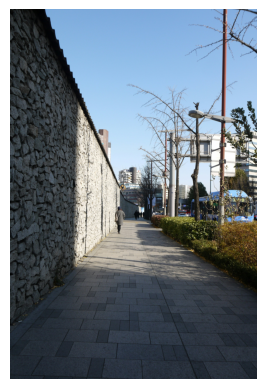

In [8]:
url = "https://images.unsplash.com/photo-1594098742644-314fedf61fb6?q=80&w=2672&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
image = Image.open(requests.get(url, stream=True).raw)

plt.imshow(image)
plt.axis("off")
plt.show()

We wil use the `image_segmentation` method from the `InferenceClient`.

In [ ]:
response = client.image_segmentation(
    model="sergiopaniego/test-segformer-b0-segments-sidewalk-finetuned",
    image="https://images.unsplash.com/photo-1594098742644-314fedf61fb6?q=80&w=2672&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",
)

print(response)

In [ ]:
image_array = np.array(image)
segmentation_map = np.zeros_like(image_array)

for result in response:
    mask = np.array(result['mask'])
    label = result['label']

    label_index = list(id2label.values()).index(label)

    color = sidewalk_palette[label_index]

    for c in range(3):
        segmentation_map[:, :, c] = np.where(mask, color[c], segmentation_map[:, :, c])

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image_array)
plt.imshow(segmentation_map, alpha=0.5)
plt.axis("off")
plt.show()